## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability



In [48]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)



a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
rows = df.shape[0]
print("The number of rows in the dataset: {}".format(rows))

The number of rows in the dataset: 294478


c. The number of unique users in the dataset.

In [4]:
users = df.user_id.nunique()
print("The number of users in the dataset: {}".format(users))

The number of users in the dataset: 290584


d. The proportion of users converted.

In [5]:
convrted_users = df.converted.mean()
print("The proportion of users converted: {0:.2%}".format(convrted_users))

The proportion of users converted: 11.97%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
number_times_nmatch = df.query('group == "treatment" & landing_page != "new_page" or group != "treatment" & landing_page == "new_page"')['user_id'].count()
print('The number of times the new pages and  treatmens not matched: {}'.format(number_times_nmatch))

The number of times the new pages and  treatmens not matched: 3893


f. Do any of the rows have missing values?

In [7]:
null_val = df.isnull().sum().sum()
print('The number of null values: {}'.format(null_val))

The number of null values: 0




a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query('group == "treatment" & landing_page != "new_page" or group != "treatment" & landing_page == "new_page"').index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
users2 =df2.user_id.nunique()
print("The number of users in the dataset in the new data frame: {}".format(users2))

The number of users in the dataset in the new data frame: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
print('The duplicated user ID:')
df2[df2.duplicated(['user_id'])]

The duplicated user ID:


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
print('The row information for the repeated user ID:')
df2.query('user_id == "773192"')

The row information for the repeated user ID:


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop([2893])

In [14]:
duplicated_users = df2.user_id.duplicated().sum()
print('The duplicated user ID: {}'.format(duplicated_users))

The duplicated user ID: 0




a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
convrted_users2 = df2.converted.mean()
print("The probability of users converted: {0:.2%}".format(convrted_users))

The probability of users converted: 11.97%


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
converted_control = df2.query('group == "control" & converted == 1').shape[0]/df2.query('group == "control"').shape[0]
print('The probability of users converted in control group: {0:.2%}'.format(converted_control))

The probability of users converted in control group: 12.04%


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
converted_treatment = df2.query('group == "treatment" & converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]
print('The probability of users converted in treatment group: {0:.2%}'.format(converted_treatment))

The probability of users converted in treatment group: 11.88%


d. What is the probability that an individual received the new page?

In [18]:
landing_new_page = df2.query('landing_page == "new_page"').shape[0]/df2['landing_page'].shape[0]
print("The probability of users received the new page: {0:.2%}".format(landing_new_page))

The probability of users received the new page: 50.01%


In [19]:
(converted_treatment - converted_control)*100

-0.15782389853555567

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.


> **There is insufficient evidence to say one of the two pages lead more conversions. We can see the difference percentage between them are very small. About 0.15%, which is not a sufficient evidence for making a decision from it**

<a id='ab_test'></a>
### Part II - A/B Test



 




`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.



> **Null hypothesis H0 = $P_{new} - P_{old} <= 0$** 

> **Alternative hypothesis H1 = $P_{new} - P_{old} > 0$**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>



a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
cr_new = df2.query('group == "treatment"')['converted'].mean()
print('The convert rate: {}'.format(cr_new))

The convert rate: 0.11880806551510564


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
cr_old = df2.query('group == "control"')['converted'].mean()
print('The convert rate: {}'.format(cr_old))

The convert rate: 0.1203863045004612


c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"').shape[0]
print('The number of new pages are: {}'.format(n_new))

The number of new pages are: 145310


d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
print('The number of old pages are: {}'.format(n_old))

The number of old pages are: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1] , size=n_new , p=(cr_new, (1-cr_new))).mean()
print(new_page_converted)

0.8811299979354483


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1] , size=n_old , p=[cr_old, (1-cr_old)]).mean()
print(old_page_converted)

0.8789253410796151


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
obs_diff = new_page_converted - old_page_converted
obs_diff

0.0013237848966782817

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
p_diffs =[]
for _ in range(10000):
    new_page_converted = np.random.choice([0,1] , size=n_new , p=[cr_new, (1-cr_new)]).mean()
    old_page_converted = np.random.choice([0,1] , size=n_old , p=[cr_old, (1-cr_old)]).mean()
    diffs = (new_page_converted - old_page_converted)
    p_diffs.append(diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

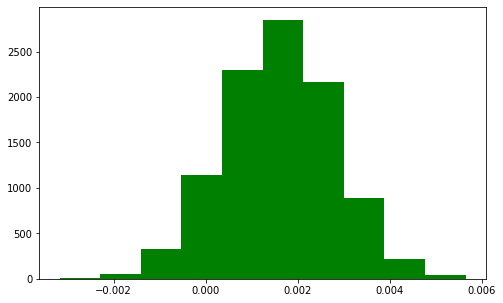

In [36]:
p_diffs = np.array(p_diffs)
plt.figure (figsize=(8,5))
plt.hist( p_diffs ,color="g");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

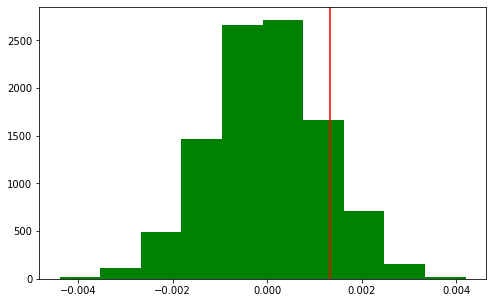

In [37]:
null_values = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.figure(figsize=(8,5))
plt.hist(null_values, color='g');
plt.axvline(obs_diff, color='r');

In [38]:
(null_values > obs_diff).mean()

0.1343

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **At part `j` I just computed the p-value to decide whether to _reject the null_ or _fail to reject the null_. p-value is above `0.05`. Which is greater than type I error 5%. To `reject the null`, at most the p-value must be less than or equal to 0.05. Our p-value is more than 0.05. So that mean we `fail to reject the null`. In other words, it is true to say that the old pages have more conversion rate than the new one.** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].shape[0]
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [46]:
z_score , p_value = sm.stats.proportions_ztest((convert_new,convert_old),(n_new,n_old))
print('The Z-score value: {} and the p-value: {}'.format(z_score ,p_value))

The Z-score value: -1.3109241984234394 and the p-value: 0.18988337448195103


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **z-score that computed above is a value to make a decetion for either to choose evaluate the new page or stay on the old age. Our z-score vaalue is below the critical value `1.96`. Which is mean that we `fail to reject the null hypothesis`. The p-value still above `0.05` type I error, so this mean we have the same result on the previous questions `j and k`. Which is we `fail to reject the null`.**

In [44]:
start = df2.timestamp.min()
end = df2.timestamp.max()
df2.timestamp.max()
print('The start of the experiment: {}'.format(start))
print('The end of the experiment: {}'.format(end))

The start of the experiment: 2017-01-02 13:42:05.378582
The end of the experiment: 2017-01-24 13:41:54.460509


> **We can see the period of experiment about 22 days. It's better to run the experiment longer to make the decision whether to launch the new page or stay on the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?


>**Because we want to predict one value from two choices. And our response and explanatory variables are categorical data type. So, We will use logistic regression. Which is used for categorical data.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [53]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [54]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [55]:
reg_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [57]:
reg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        07:55:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> **The p-value here `0.19` is not differ from the p-value we found in `Part II` which is about `0.190`. Here null and alternative hypotheses are either equal to 0 or not.**

> **Null hypothesis H0 = $P_{new} - P_{old} = 0$** 

> **Alternative hypothesis H1 = $P_{new} - P_{old} != 0$**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
> **We can consider other factors to influence converts prediction. Like which days and time they converts. What gender are they? How old are they? From which country they are? From what education level are they? all these information help us to enhance our converts predection.**

> **There are many disadvantages in adding more explanatory variables to predict a response variable:** 
* **Non-linearity of the response-predictor relationships**
* **Correlation of error terms**
* **Non-constant Variance and Normally Distributed Errors**
* **Outliers/ High leverage points**
* **Multicollinearity**

> **These problems may lead us to wrong prediction and we must consider that when we add more explanatory variables to our regression model**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [59]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [63]:
country = df_new.country.unique()
print('The countries that our users from: {}'.format(country))

The countries that our users from: ['UK' 'US' 'CA']


In [67]:
### Create the necessary dummy variables
df_new[['UK','US','CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
### Fit Your Linear Model And Obtain the Results
reg_mod_2 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US']]).fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [90]:
reg_mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        10:01:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

> **Summary above shows us that p-value for countries are above `0.05` type I error. That’s indicate country explanatory variable for each country `fail to reject the null hypothesis` and there is no statistically significant relationship between our variables and the response variable**

In [88]:
np.exp(reg_mod_2.params)

intercept    0.136795
ab_page      0.985168
UK           0.960062
US           1.009932
dtype: float64

> **Holding all other variables constant:**
* **For each 1 unit increase in ab_page, converted is `0.98` times as likely.**
* **Converted is `0.96` times as likely on a UK user than CA user.**
* **Converted is `1.01` times as likely on a US user than CA user.**

<a id='conclusions'></a>
## Conclusions

For this project, e-commerce website wants to make a decision whether to launch the new page, keep the old page perhaps run the experiment longer to make their decision. 

> From the data analysis, we found that the new page not performing better than the old page. Even when we try to check if there is a country performing better, we fail to reject the null.

> The duration of this experiment was 22 days. The company should run the experiment another 20 days, or keep the old page and start to develop another new page. But of course the company shouldn’t launch the new page.



